In [1]:
from ddim import Diffusion, create_alpha_schedule
from predictor import BayesPredictor, train_predictor

In [43]:
import os
import tempfile

import imageio
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [49]:
def generate_data(batch_size):
    segments = [((0, 0), (0, 1)), ((0, 0.5), (0.5, 0.5)), ((0.5, 0), (0.5, 1)), ((1.0, 0), (1.0, 1.0))]
    points = []
    for segment in segments:
        p1 = np.array(segment[0])
        p2 = np.array(segment[1])
        for i in range(100):
            points.append(p1 + (p2 - p1) * (i / 99))
    points = np.stack(points)
    
    def generate_rejection_samples():
        samples = np.random.uniform(size=(batch_size, 1, 2)) * 2 - 0.5
        dists = np.sqrt(np.min(np.sum((samples - points[None]) ** 2, axis=-1), axis=1))
        return samples[dists < 0.05][:, 0]
    
    results = []
    while sum(len(x) for x in results) < batch_size:
        results.append(generate_rejection_samples())
    return (np.concatenate(results, axis=0)[:batch_size] - np.array([0.5, 0.5])) * 2.5

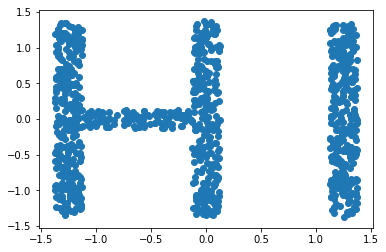

In [50]:
data = generate_data(1000)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [51]:
diffusion = Diffusion(create_alpha_schedule(num_steps=100))
model = BayesPredictor(diffusion, data)

In [59]:
images = []
with tempfile.TemporaryDirectory() as tempdir:
    x_t = np.random.normal(size=(300, 2))
    for t in tqdm(range(1, diffusion.num_steps)[::-1]):
        ts = np.array([t] * x_t.shape[0])
        x_t = diffusion.ddim_previous(x_t, ts, model.predict_epsilon(x_t, ts))
        if t % 2:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.ylim(-3, 3)
            plt.xlim(-3, 3)
            plt.scatter(x_t[:, 0], x_t[:, 1])
            ax.set_aspect('equal', adjustable='box')
            filepath = os.path.join(tempdir, 'out.png')
            plt.savefig(filepath)
            plt.close()
            images.append(imageio.imread(filepath))

In [60]:
imageio.mimsave('animation.gif', images + ([images[-1]] * 20), fps=20)